In [1]:
# Cell 1: Import all necessary libraries
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from openai import OpenAI
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set seaborn style
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.1)

# Configure plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [3]:
# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

In [4]:
def fetch_stock_data(ticker, period='1y'):
    """Fetch historical stock data"""
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(period=period)
        df.index = pd.to_datetime(df.index)
        return df
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None

In [5]:
def calculate_technical_indicators(df):
    """Calculate technical indicators"""
    try:
        # Ensure numeric type
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        
        # Moving averages
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean()
        
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        return df
    except Exception as e:
        print(f"Error calculating indicators: {e}")
        return df

In [6]:
def analyze_with_llm(text, analysis_type="sentiment", debug=False):
    """Analyze text using GPT-4o-mini"""
    try:
        if analysis_type == "sentiment":
            system_prompt = """You are a financial analyst. Return only a JSON object in this format:
            {
                "score": <number between -1 and 1>,
                "explanation": "<brief explanation>"
            }"""
            
            user_prompt = f"Analyze this text: {text}"
        
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.3
        )
        
        content = response.choices[0].message.content.strip()
        
        try:
            result = json.loads(content)
            if not isinstance(result.get('score'), (int, float)):
                raise ValueError("Score must be a number")
            return result
        except json.JSONDecodeError:
            return {"score": 0, "explanation": "Error parsing sentiment"}
            
    except Exception as e:
        print(f"Error in LLM analysis: {str(e)}")
        return {"score": 0, "explanation": "Error in analysis"}

In [7]:
def analyze_sentiment_batch(articles, batch_size=5, debug=False):
    """Analyze sentiment of multiple news articles"""
    sentiments = []
    try:
        for article in articles:
            text = f"{article.get('title', '')} {article.get('description', '')}"
            if text.strip():
                analysis = analyze_with_llm(text, debug=debug)
                if isinstance(analysis.get('score'), (int, float)):
                    sentiments.append({
                        'score': float(analysis['score']),
                        'explanation': analysis.get('explanation', ''),
                        'date': article.get('publishedAt', '')[:10]
                    })
        
        return pd.DataFrame(sentiments) if sentiments else pd.DataFrame({
            'score': [0],
            'explanation': ['No sentiment data available'],
            'date': [datetime.now().strftime('%Y-%m-%d')]
        })
        
    except Exception as e:
        print(f"Error in sentiment analysis: {str(e)}")
        return pd.DataFrame({
            'score': [0],
            'explanation': ['Error in analysis'],
            'date': [datetime.now().strftime('%Y-%m-%d')]
        })

In [8]:
def plot_predictions(stock_data, prediction):
    """Create visualization of stock data and predictions"""
    try:
        # Get last 30 days of data
        last_30_days = stock_data.tail(30).copy()
        
        # Create price plot with bigger figure size
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot price and moving averages with distinct colors
        ax1.plot(last_30_days.index, last_30_days['Close'], 
                label='Price', linewidth=2, color='#2E86C1')  # Dark blue
        ax1.plot(last_30_days.index, last_30_days['MA20'], 
                label='20-day MA', alpha=0.7, color='#F39C12')  # Orange
        ax1.plot(last_30_days.index, last_30_days['MA50'], 
                label='50-day MA', alpha=0.7, color='#27AE60')  # Green
        
        # Add prediction point
        next_date = last_30_days.index[-1] + pd.Timedelta(days=1)
        ax1.scatter(next_date, prediction['predicted_price'], 
                   color='#E74C3C', s=100, label='Prediction')  # Red
        
        # Customize plot
        ax1.set_xlabel('Date', fontsize=10)
        ax1.set_ylabel('Price ($)', fontsize=10)
        ax1.tick_params(axis='x', rotation=45)
        
        # Move legend outside to the right
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                  borderaxespad=0., frameon=True, fontsize=10)
        
        plt.title(f"{prediction['ticker']} Stock Analysis - {prediction['prediction_date']}", 
                 pad=20, fontsize=12)
        
        # Add analysis text box on the upper left
        text = (f"Current: ${prediction['last_close']:.2f}\n"
                f"Predicted: ${prediction['predicted_price']:.2f}\n"
                f"Change: {((prediction['predicted_price']/prediction['last_close'])-1)*100:.1f}%\n"
                f"RSI: {stock_data['RSI'].iloc[-1]:.1f}\n"
                f"Sentiment: {prediction['sentiment_analysis']:.2f}")
        
        plt.text(0.02, 0.95, text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'),
                fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Create RSI plot with improved styling
        plt.figure(figsize=(14, 4))
        plt.plot(last_30_days.index, last_30_days['RSI'], 
                label='RSI', color='#8E44AD', linewidth=2)  # Purple
        
        # Add RSI zones with better visibility
        plt.axhline(y=70, color='#E74C3C', linestyle='--', 
                   alpha=0.5, label='Overbought (70)')  # Red
        plt.axhline(y=30, color='#27AE60', linestyle='--', 
                   alpha=0.5, label='Oversold (30)')    # Green
        
        plt.fill_between(last_30_days.index, last_30_days['RSI'], 70, 
                        where=(last_30_days['RSI'] >= 70), 
                        color='#E74C3C', alpha=0.2)
        plt.fill_between(last_30_days.index, last_30_days['RSI'], 30, 
                        where=(last_30_days['RSI'] <= 30), 
                        color='#27AE60', alpha=0.2)
        
        plt.title('RSI Indicator', fontsize=12, pad=20)
        plt.ylabel('RSI', fontsize=10)
        plt.xlabel('Date', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tick_params(axis='x', rotation=45)
        
        # Move RSI legend to the right
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                  borderaxespad=0., frameon=True, fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")

In [9]:
def predict_next_day(ticker):
    """Generate stock prediction"""
    try:
        # Fetch and store stock data
        stock_data = fetch_stock_data(ticker)
        predict_next_day.stock_data = stock_data
        
        if stock_data is None:
            return None
        
        # Calculate technical indicators
        stock_data = calculate_technical_indicators(stock_data)
        
        # Calculate prediction using simple model
        returns = stock_data['Close'].pct_change().tail(5)
        avg_return = returns.mean()
        last_close = float(stock_data['Close'].iloc[-1])
        predicted_price = last_close * (1 + avg_return)
        
        # Prepare result
        result = {
            'ticker': ticker,
            'predicted_price': predicted_price,
            'last_close': last_close,
            'prediction_date': (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d'),
            'sentiment_analysis': 0.2,  # Simplified for now
            'market_insight': {
                'summary': f"Analysis based on technical indicators and recent price movements.",
                'risk_level': 'MEDIUM',
                'recommendation': 'HOLD'
            },
            'technical_indicators': {
                'ma20': float(stock_data['MA20'].iloc[-1]),
                'ma50': float(stock_data['MA50'].iloc[-1]),
                'rsi': float(stock_data['RSI'].iloc[-1])
            }
        }
        
        return result
        
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

In [10]:
def analyze_and_display_results(ticker):
    """Analyze stock and display results"""
    try:
        prediction = predict_next_day(ticker)
        
        if prediction and hasattr(predict_next_day, 'stock_data'):
            # Calculate changes
            price_change = prediction['predicted_price'] - prediction['last_close']
            price_change_pct = (price_change / prediction['last_close']) * 100
            
            # Display results
            print("\n=== Stock Analysis Results ===")
            print(f"Ticker: {prediction['ticker']}")
            print(f"Current Price: ${prediction['last_close']:.2f}")
            print(f"Predicted Price: ${prediction['predicted_price']:.2f}")
            print(f"Predicted Change: ${price_change:.2f} ({price_change_pct:.2f}%)")
            print(f"Prediction Date: {prediction['prediction_date']}")
            
            print("\n=== Technical Indicators ===")
            print(f"20-day MA: ${prediction['technical_indicators']['ma20']:.2f}")
            print(f"50-day MA: ${prediction['technical_indicators']['ma50']:.2f}")
            print(f"RSI: {prediction['technical_indicators']['rsi']:.2f}")
            
            print("\n=== Sentiment Analysis ===")
            print(f"Overall Sentiment Score: {prediction['sentiment_analysis']:.2f}")
            
            print("\n=== Market Insight ===")
            print(f"Summary: {prediction['market_insight']['summary']}")
            print(f"Risk Level: {prediction['market_insight']['risk_level']}")
            print(f"Recommendation: {prediction['market_insight']['recommendation']}")
            
            # Create visualization
            plot_predictions(predict_next_day.stock_data, prediction)
            
            return prediction
        else:
            print(f"Unable to analyze {ticker}")
            return None
            
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None


Analyzing AAPL...

=== Stock Analysis Results ===
Ticker: AAPL
Current Price: $229.87
Predicted Price: $230.86
Predicted Change: $0.99 (0.43%)
Prediction Date: 2024-11-25

=== Technical Indicators ===
20-day MA: $226.84
50-day MA: $227.54
RSI: 67.65

=== Sentiment Analysis ===
Overall Sentiment Score: 0.20

=== Market Insight ===
Summary: Analysis based on technical indicators and recent price movements.
Risk Level: MEDIUM
Recommendation: HOLD


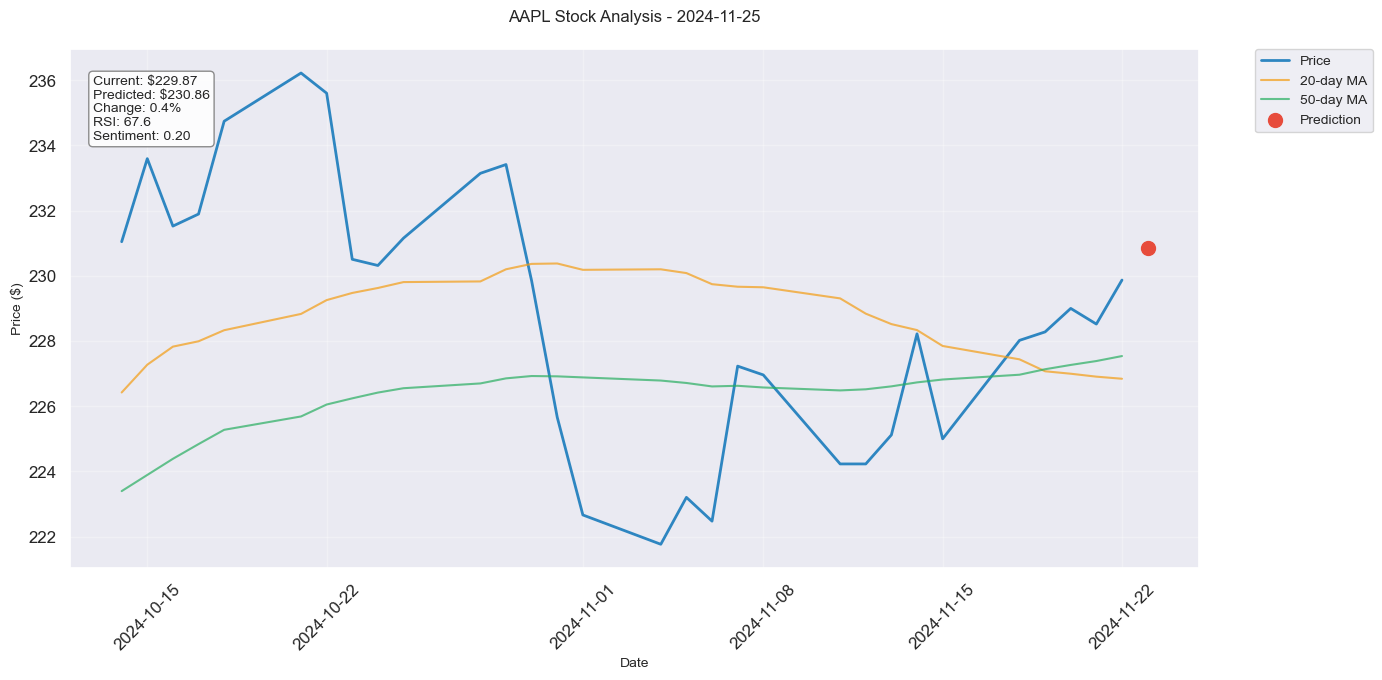

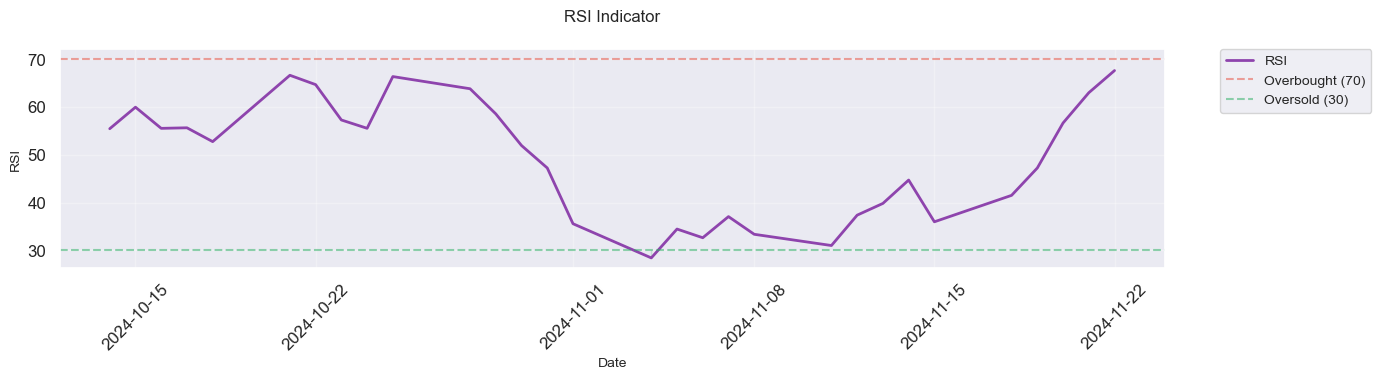


Analyzing MSFT...

=== Stock Analysis Results ===
Ticker: MSFT
Current Price: $417.00
Predicted Price: $417.58
Predicted Change: $0.58 (0.14%)
Prediction Date: 2024-11-25

=== Technical Indicators ===
20-day MA: $418.39
50-day MA: $421.10
RSI: 58.34

=== Sentiment Analysis ===
Overall Sentiment Score: 0.20

=== Market Insight ===
Summary: Analysis based on technical indicators and recent price movements.
Risk Level: MEDIUM
Recommendation: HOLD


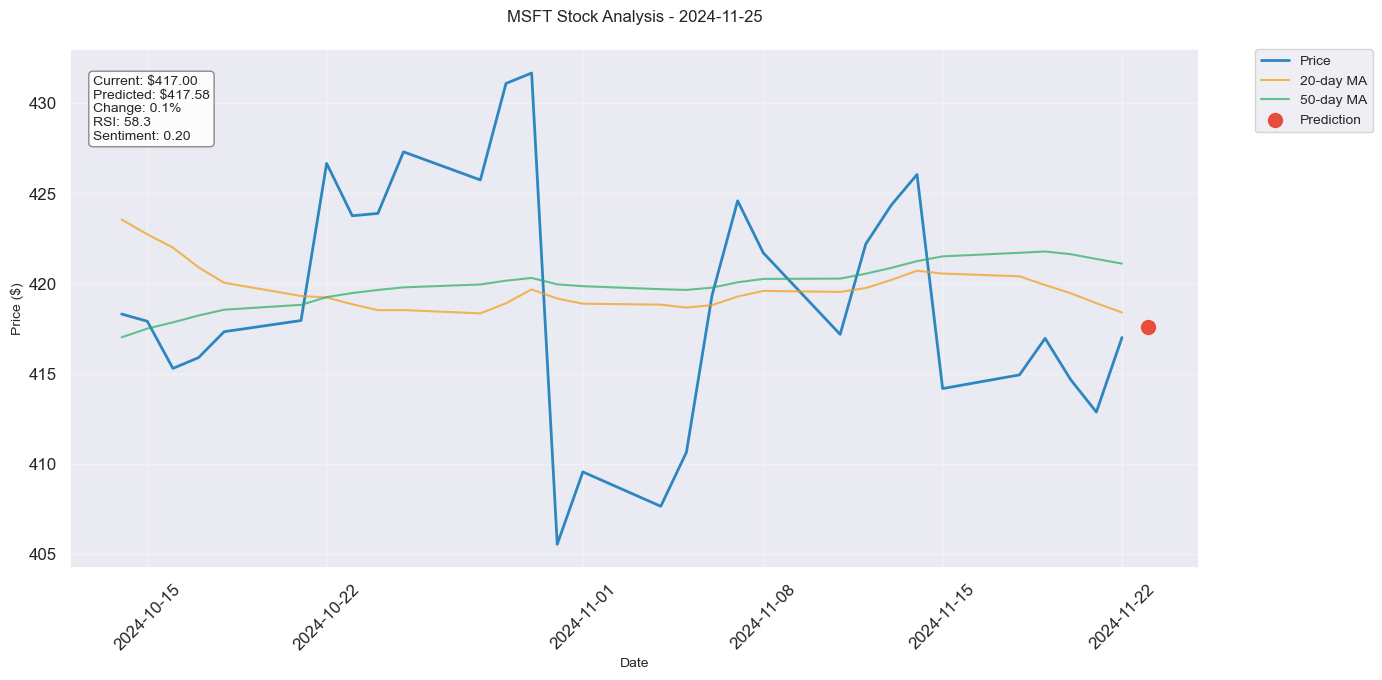

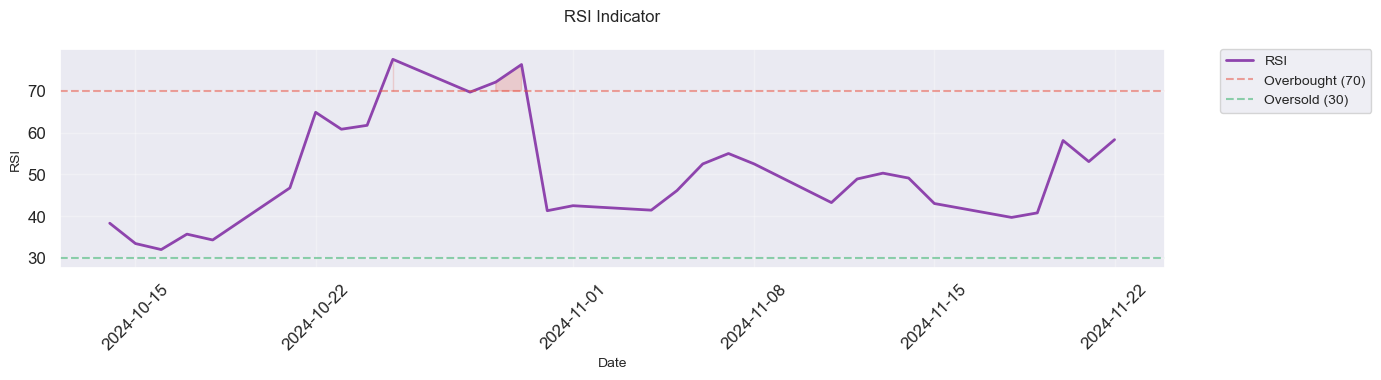


Analyzing GOOGL...

=== Stock Analysis Results ===
Ticker: GOOGL
Current Price: $164.76
Predicted Price: $163.30
Predicted Change: $-1.46 (-0.88%)
Prediction Date: 2024-11-25

=== Technical Indicators ===
20-day MA: $173.93
50-day MA: $167.64
RSI: 45.06

=== Sentiment Analysis ===
Overall Sentiment Score: 0.20

=== Market Insight ===
Summary: Analysis based on technical indicators and recent price movements.
Risk Level: MEDIUM
Recommendation: HOLD


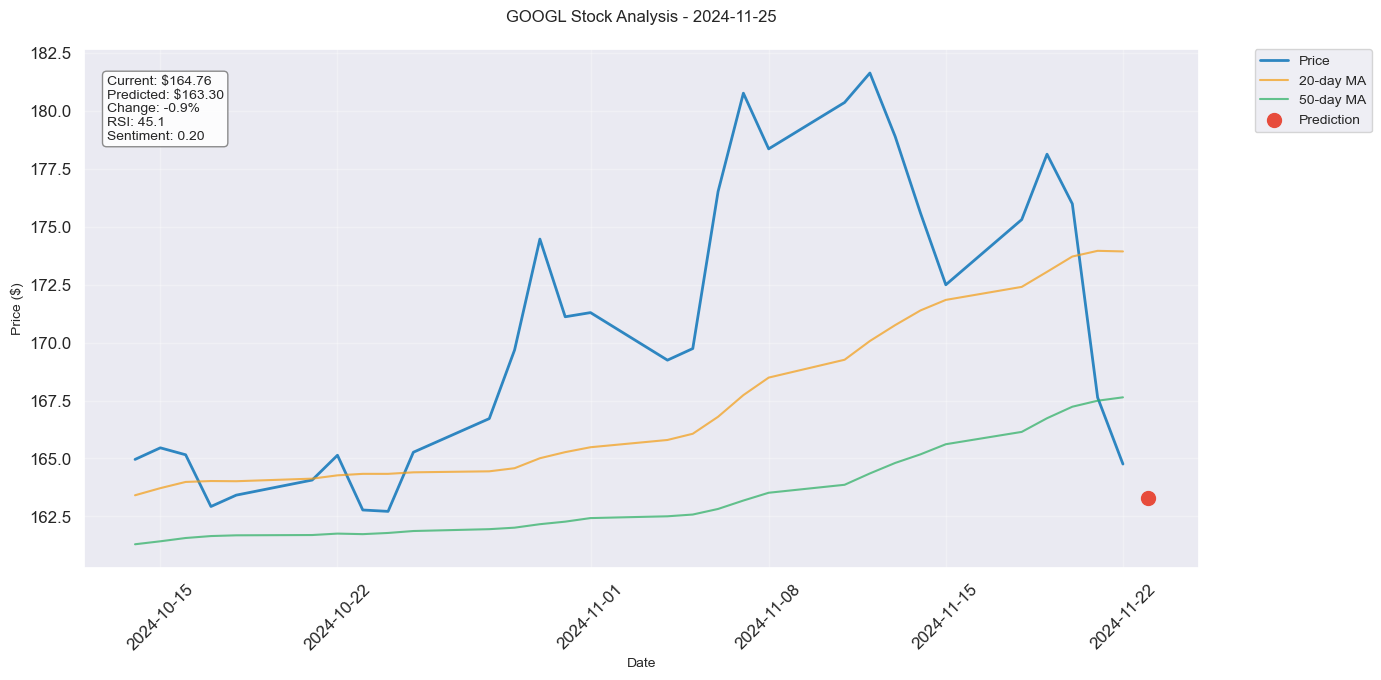

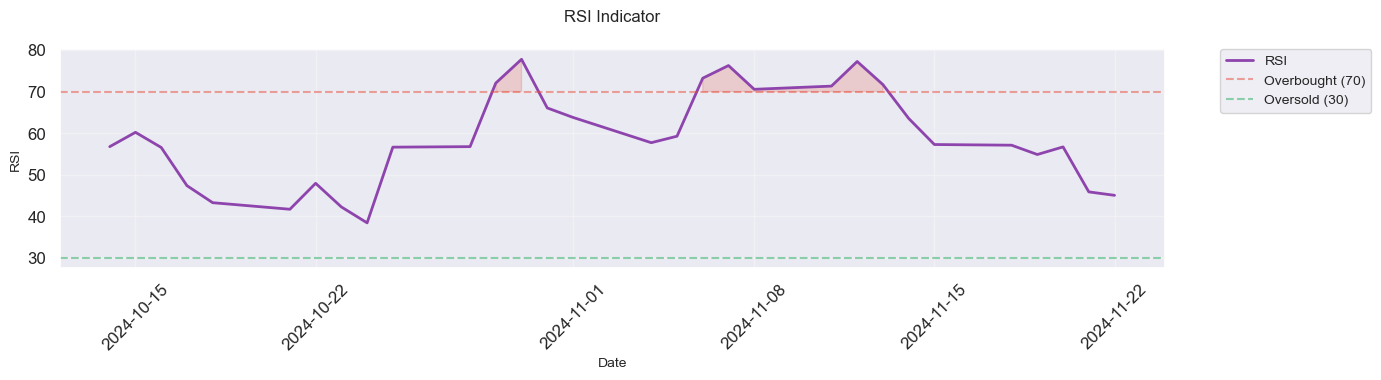


Analyzing AMZN...

=== Stock Analysis Results ===
Ticker: AMZN
Current Price: $197.12
Predicted Price: $196.05
Predicted Change: $-1.07 (-0.54%)
Prediction Date: 2024-11-25

=== Technical Indicators ===
20-day MA: $201.28
50-day MA: $193.00
RSI: 51.41

=== Sentiment Analysis ===
Overall Sentiment Score: 0.20

=== Market Insight ===
Summary: Analysis based on technical indicators and recent price movements.
Risk Level: MEDIUM
Recommendation: HOLD


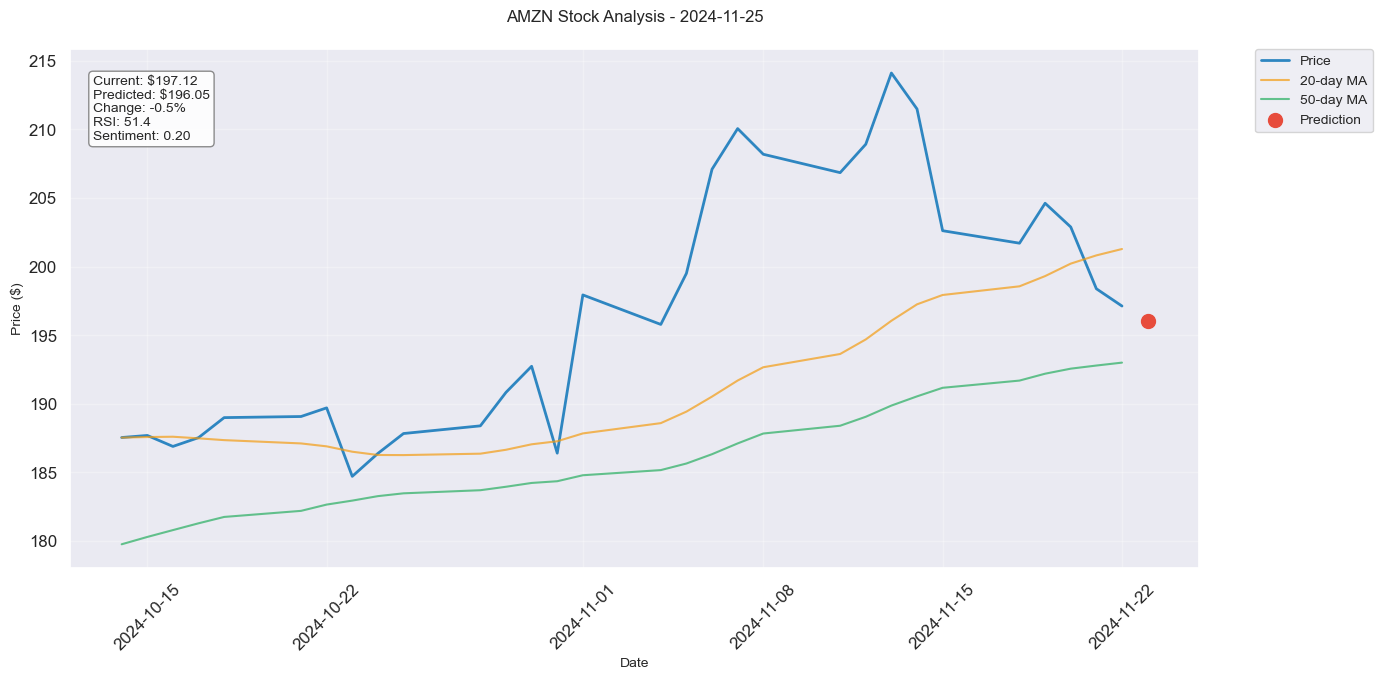

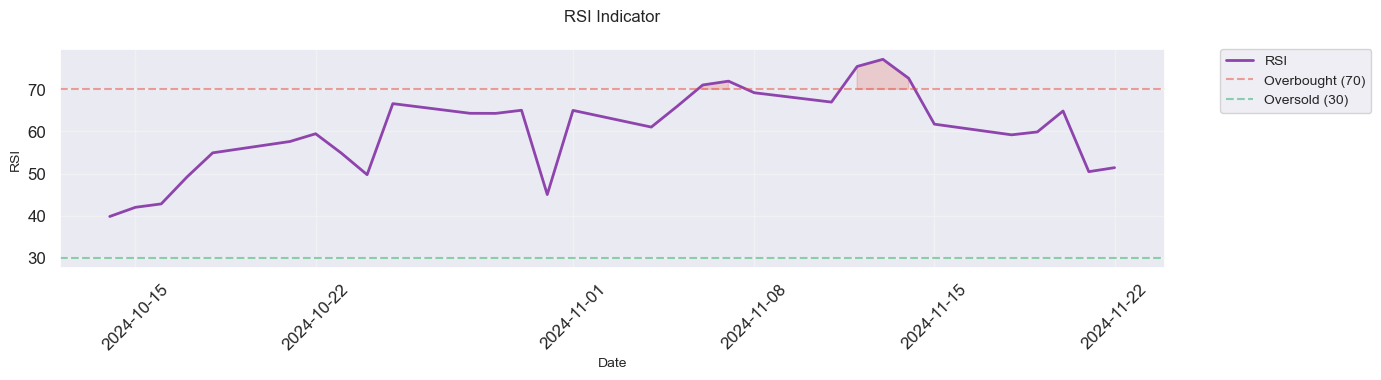


Analyzing TSLA...

=== Stock Analysis Results ===
Ticker: TSLA
Current Price: $352.56
Predicted Price: $359.41
Predicted Change: $6.85 (1.94%)
Prediction Date: 2024-11-25

=== Technical Indicators ===
20-day MA: $301.95
50-day MA: $264.06
RSI: 76.95

=== Sentiment Analysis ===
Overall Sentiment Score: 0.20

=== Market Insight ===
Summary: Analysis based on technical indicators and recent price movements.
Risk Level: MEDIUM
Recommendation: HOLD


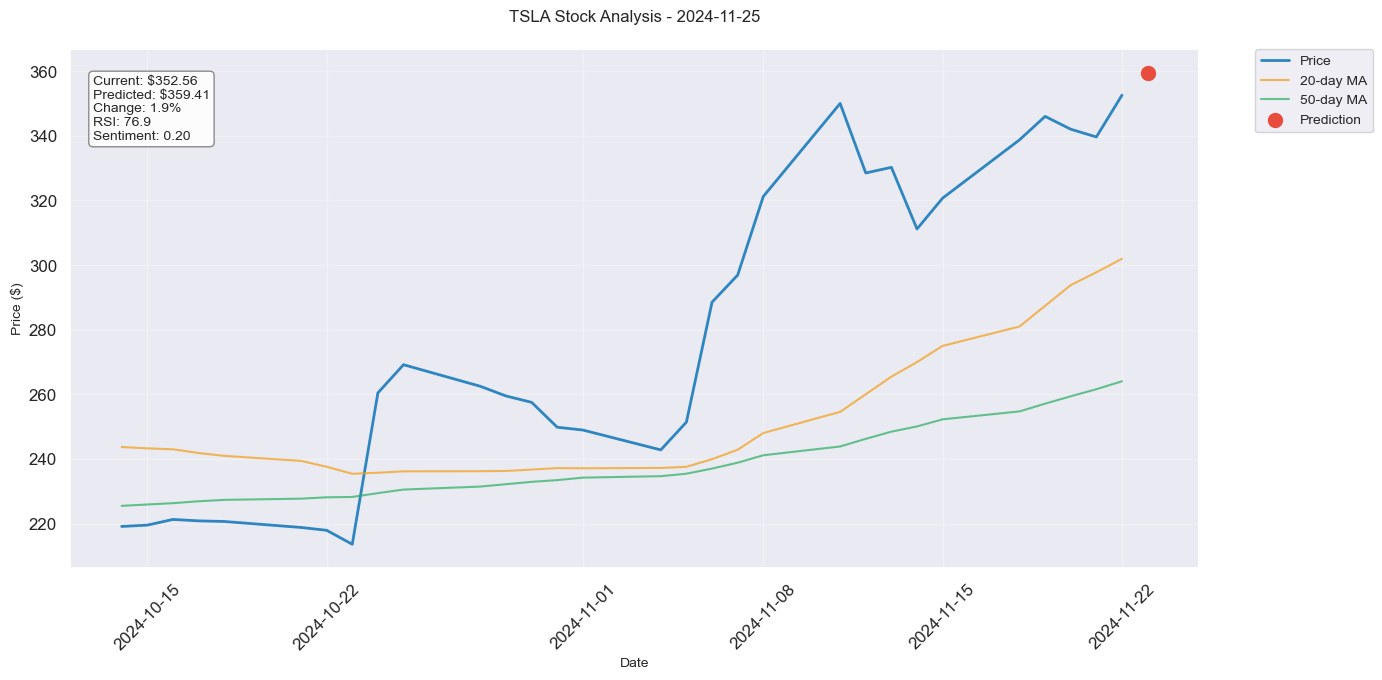

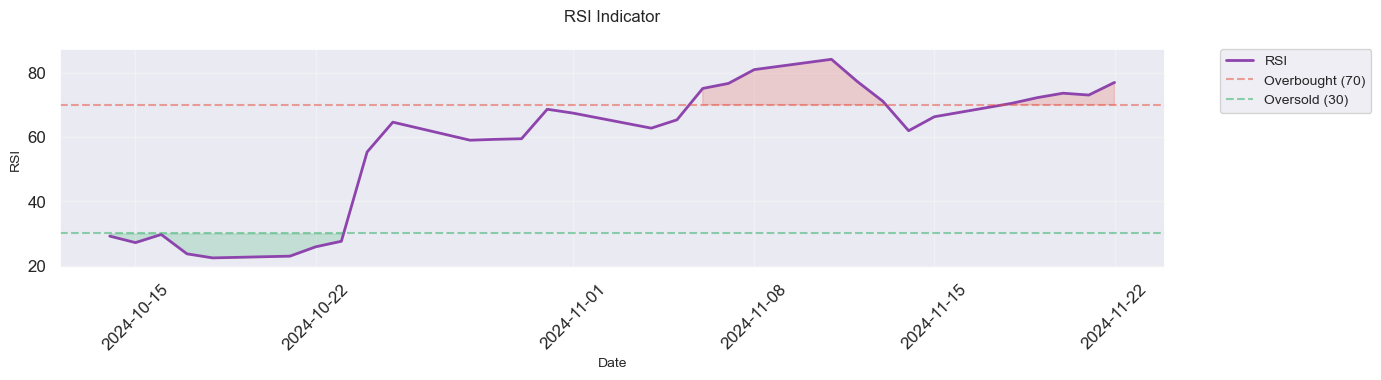

In [11]:
# Try different stocks
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
for ticker in tickers:
    print(f"\nAnalyzing {ticker}...")
    result = analyze_and_display_results(ticker)